<a href="https://colab.research.google.com/github/andtab/andtab.github.io/blob/master/A3_Tabri_Andrew_1000414875.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A3: TD(n) and Mountain Car**

In this assignment we are going to apply the TD(n) methods to solve the Mountain Car problem.
<br>
<br>
By now, you should know how to load OpenAI gym environments:

`env = gym.make(`<font color = 'mahogany'>`'MountainCar-v0'`</font>`)`

#**Imports**

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
import gym
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

import numpy as np
import matplotlib.pyplot as plt

# Additional imports required for this implementation
import glob
import base64
import copy 
import random
from prettytable import PrettyTable

#**Exercise 1: Prelims**

These are useful exercises to develop facility with the environment prior to the graded component of the assignment. Explore the above environment as we've done in past assignments and exercises.
<br>
Develop a MC controller and assess its performance.

**Text Response**: Inspecting the source code for the Mountain Car (MC) testing environment, we observe that an episode will terminate when the MC has hit or exceeded the flag position (0.5), with a velocity >= 0 (successful episode), or if an episode takes greater than or equal 200 steps to conclude (failed episode). MC states are represented by a tuple of `(position, velocity)`. The MC can move left, remain neutral, or move right at any given state. The built reward structure for the MC problem is -1 for every state transition.

**More notes on position and velocity for this problem...**
<br>
Position, $x$, ranges from $[1.2, 0.6]$ (inclusive)...
<br>
Velocity, $\textbf{v}$ ranges from $[-0.7, -0.7]$ (inclusive)...

when $x \geq 0.5$ and $\textbf{v} \geq 0$, we have a successful episode.

##**Action Space**

At any state, the mountain car can take one of 3 actions; push left (0), no push (1), push right (2), as presented in the below table.

In [4]:
# This cell is used to display the table illustrating the relation ship between
# input and performed logic action

# Instantiate table class
action_space_table = PrettyTable()

# Provide title to table
action_space_table.title = 'Input-Action Mapping'

# Provide field names to table
action_space_table.field_names = ['Input', 'Logic Action']

# Populate table rows
action_space_table.add_row([0, 'Push Left'])
action_space_table.add_row([1, 'No Push'])
action_space_table.add_row([2, 'Push Right'])
action_space_table.border
print(action_space_table)

+------------------------+
|  Input-Action Mapping  |
+--------+---------------+
| Input  |  Logic Action |
+--------+---------------+
|   0    |   Push Left   |
|   1    |    No Push    |
|   2    |   Push Right  |
+--------+---------------+


##**Randomized Action Selection Model**

Developed code to demonstrate the MC taking random action selection, afterwards displaying the results in an embedded video. The code for implementing the video replay functionality takes guidance from the following notebook, linked <a href = "https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT">here</a>: 

###Display Video Replay of MC Episode

In [5]:
# Establish video size
display = Display(visible=0, size=(1400, 900))
display.start()

# Function for video replay
def display_video():
  # Produce a list with all the video files created in the video folder of the
  # notebook
  mp4list = glob.glob('video/*.mp4')

  # If video folder contains a video file...
  if len(mp4list) > 0:

    # Take the first video found in the folder 
    mp4 = mp4list[0]

    # When video is opened with the 'read' method, it is encoded as a base64 
    # string - we must convert this data into a video of mp4 format
    video = open(mp4, 'rb').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

###Random Action MC Episode Run (Output Video Recording)

As we can see... performance isn't all to great here. Let's see if TD Learning control methods can be implemented to improve this situation.

In [6]:
# Apply the Monitor wrapper to the regular environment specification in order
# for a replay to be recorded
env = gym.wrappers.Monitor(gym.make('MountainCar-v0'),'video', force = True, resume = True)

# Run an MC episode with random actions being taken
env.reset()

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  print('obs2=', env.env.state)
  ipythondisplay.clear_output(wait=True)      
  
  if done:
    break
    

env.close()
print("Iterations that were run:", i)
print("step i",i,"action=",action)
print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

display_video()

Iterations that were run: 199
step i 199 action= 1
obs= [-0.32044734  0.00359201] reward= -1.0 done= True info= {'TimeLimit.truncated': True}


###Random Action MC Episode Run (Output Episode Log)

In [ ]:
# This code block will run an episode just like the previous block, although
# instead of the episode replay being in the form of the video, we will have
# a text output of the states visited, actions taken, and rewards earned by the
# MC until termination
env = gym.make('MountainCar-v0')

env.reset()

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  
  if done:
    break
    
env.close()
print("Iterations that were run:", i)
print("step i",i,"action=",action)
print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

#**Helper Functions**

##**State Space Discretization**

States in the cartpole environment are defined by the pole's position, linear velocity, angle from the vertical, and angular velocity. These are continuous quantities, which are currently not compatible with our development for policy, action value, and so on. Therefore, we require to discretize the state space. The helper functions below help achieve this aim.

###Position Quantization

In [8]:
# Position quantization helper function
# 11 buckets were constructed for the quantization of 
# position in this implementation
def position_quantization(input_position):

  if input_position == -1.2:
    position = 0
    
  elif input_position > -1.2 and input_position < -1:
    position = 1

  elif input_position >= -1 and input_position < -0.8:
    position = 2

  elif input_position >= -0.8 and input_position < -0.6:
    position = 3

  elif input_position >= -0.6 and input_position < -0.4:
    position = 4

  elif input_position >= -0.4 and input_position < -0.2:
    position = 5

  elif input_position >= -0.2 and input_position < 0:
    position = 6

  elif input_position >= 0 and input_position < 0.2:
    position = 7

  elif input_position >= 0.2 and input_position < 0.4:
    position = 8

  elif input_position >= 0.4 and input_position < 0.5:
    position = 9

  else:
    position = 10

  # Return the resulting position index
  return position

###Velocity Quantization

In [9]:
# The logic described for the 'position_quantization' helper function
# applies similarly here
# 11 buckets were constructed for the quantization of 
# velocity in this implementation
def velocity_quantization(input_vel):

  if input_vel == -0.7:
    velocity = 0

  elif input_vel > -0.7 and input_vel < -0.5:
    velocity = 1

  elif input_vel >= -0.5 and input_vel < -0.3:
    velocity = 2

  elif input_vel >= -0.3 and input_vel < -0.1:
    velocity = 3

  elif input_vel >= -0.1 and input_vel < 0:
    velocity = 4

  elif input_vel == 0:
    velocity = 5

  elif input_vel > 0 and input_vel < 0.1:
    velocity = 6

  elif input_vel >= 0.1 and input_vel < 0.3:
    velocity = 7

  elif input_vel >= 0.3 and input_vel < 0.5:
    velocity = 8

  elif input_vel >= 0.5 and input_vel < 0.7:
    velocity = 9

  else:
    velocity = 10

  return velocity

###State Discretization

In [10]:
# This function makes use of the previous helper functions in order to take
# the state of the agent, represented 
# as a tuple (position, velocity), and output its
# discretized counterpart, based on the buckets developed previously
def state_discretization(input_state):

  # Unpack input state into its two components
  position, velocity = input_state

  # Discretize each of the two variables representing the CartPole's state
  position_discrete = position_quantization(position)
  velocity_discrete = velocity_quantization(velocity)   

  # Store the discretized version of the CartPole's state into a tuple
  state_discrete = (position_discrete, velocity_discrete)

  # Output the discretized state tuple
  return state_discrete

##**Policy Helper Functions**

###Action Selection

In [11]:
# Action selection for the agent - based on the probability weights for each
# action in a given state
def action_selection(policy_input, state_input):

  # From the current state, extract the possible actions and their corresponding
  # weights
  action_set = list(policy_input[state_input].keys())
  action_weights = list(policy_input[state_input].values())

  # Probabilistically an action based on each action's weight
  selected_action = random.choices(action_set, action_weights, k= 1)[0]

  # Return the selected action 
  return selected_action

###ε-Greedy Policy Generation

In [12]:
# Generate a behaviour policy (ε-greedy) given a target policy
# INPUTS: target policy, and epsilon (expects epsilon > 0)
def eps_greedy_policy_generator(input_policy, eps = 0.1):

  # Initialize soft_policy dictionary
  soft_policy = {}

  # Loop through each state
  for state in input_policy:

      # Determine the amount of actions that can be taken to go from current
      # state to another state (|𝒜(s)|)
      act_set_size = len(input_policy[state])

      # Determine the maximum probability of taking an action for a given state
      optimal_value = max(input_policy[state].values())

      # Determine which actions out of the state's action set |𝒜(s)|
      # are optimal, based on the calculated optimal value
      optimal_actions = [action for action in input_policy[state] if input_policy[state][action] == optimal_value]     

      # Initialize sub dictionary of the action set for the soft policy
      soft_policy_action_set = {}
       
      # Loop through each action possible in the current state
      for action in input_policy[state]:
        
        # The following if statements intend to assign probabilities of taking
        # actions in given states in accordance with the ε-soft requirements
        if action in optimal_actions:

          if len(optimal_actions) != act_set_size:
            # When the optimal value in an action set is > 0
            # When all actions for a given state are not equiprobable,
            # Set the probability of taking the optimal action to be = (1/|𝒜'(s)|)(1 - ε) + ε/|𝒜(s)|
            # Where |𝒜'(s)| represents the number of optimal actions within |𝒜(s)| (i.e. ties)
            soft_policy_action_set[action] = (1/len(optimal_actions))*(1 - eps) + eps/act_set_size

          else:
            # Otherwise, if all actions in |𝒜(s)| are equiprobable,
            # and not equal to 0, they shall remain equiprobable
            soft_policy_action_set[action] = (1/len(optimal_actions))

        else:
          # For non optimal actions, set the probability of taking
          # these actions = ε/|𝒜(s)|
          soft_policy_action_set[action] = eps/act_set_size

      # Set the newly 𝒜(s) to the current s  
      soft_policy[state] = soft_policy_action_set
  
  # Return the ε-greedy policy
  return soft_policy

###ε-Greedy Policy State Update

In [13]:
# Updates ε-greedy policy for a specified state (i.e. calculate π(s))
def eps_greedy_policy_update(input_policy_state, eps = 0.1):

  # Determine the amount of actions that can be taken to go from current
  # state to another state (|𝒜(s)|)
  act_set_size = len(input_policy_state)

  # Determine the maximum probability of taking an action for a given state
  optimal_value = max(input_policy_state.values())

  # Determine which actions out of the state's action set |𝒜(s)|
  # are optimal, based on the calculated optimal value
  optimal_actions = [action for action in input_policy_state if input_policy_state[action] == optimal_value]     

  # Initialize sub dictionary of the action set for the soft policy
  soft_policy_action_set = {}
    
  # Loop through each action possible in the current state
  for action in input_policy_state:
    
    # The following if statements intend to assign probabilities of taking
    # actions in given states in accordance with the ε-soft requirements
    if action in optimal_actions:

      if len(optimal_actions) != act_set_size:
        # When the optimal value in an action set is > 0
        # When all actions for a given state are not equiprobable,
        # Set the probability of taking the optimal action to be = (1/|𝒜'(s)|)(1 - ε) + ε/|𝒜(s)|
        # Where |𝒜'(s)| represents the number of optimal actions within |𝒜(s)| (i.e. ties)
        soft_policy_action_set[action] = (1/len(optimal_actions))*(1 - eps) + eps/act_set_size

      else:
        # Otherwise, if all actions in |𝒜(s)| are equiprobable,
        # and not equal to 0, they shall remain equiprobable
        soft_policy_action_set[action] = (1/len(optimal_actions))

    else:
      # For non optimal actions, set the probability of taking
      # these actions = ε/|𝒜(s)|
      soft_policy_action_set[action] = eps/act_set_size

  # Return the ε policy for a given state
  return soft_policy_action_set

###Argmax at Given State

In [14]:
 # Determine the argmax of the action value function at a given state
 # For use in determining the agent's optimal policy
 def argmax_action_value(action_value_function, policy, state):

  # For the given state determine the highest value which can be achieved
  # by taking an action
  optimal_value = max(action_value_function[state].values())

  # Store the list of actions which satisfy this optimal value requirement
  # in the 'optimal_actions' list
  optimal_actions = [action for action in action_value_function[state] if action_value_function[state][action] == optimal_value]

  # Determine the actions which generate the most optimal policy here
  for action in action_value_function[state]:
    
    if action not in optimal_actions:
      policy[state][action] = 0    
    else:

      if optimal_value != 0:
        policy[state][action] = (1/len(optimal_actions))

      else:
        policy[state][action] = 0  

  # Return the set of revised policy for a given state based on the action value
  # argmax for a given state
  return policy[state]

###Argmax Policy Generator (Entire State Space)



In [15]:
 # Determine the argmax of the action value function at a given state
 # For use in determining the agent's greedy policy
 def argmax_policy(action_value_function):
  
  # Dictionary to store initial policy
  policy = {}

  # Store list of possible states in a variable - use the keys of the input
  # action value function
  state_list = list(action_value_function.keys())

  # For each state  
  for state in state_list:

    action_list = list(action_value_function[state].keys())
    action_set = {}
    for action in action_list:
      action_set[action] = 0
    policy[state] = action_set

    # For the given state determine the highest value which can be achieved
    # by taking an action
    optimal_value = max(action_value_function[state].values())

    # Store the list of actions which satisfy this optimal value requirement
    # in the 'optimal_actions' list
    optimal_actions = [action for action in action_value_function[state] if action_value_function[state][action] == optimal_value]

    # Determine the actions which generate the most optimal policy here
    for action in action_value_function[state]:
      if action not in optimal_actions:
        policy[state][action] = 0    
      else:
        if optimal_value != 0:
          policy[state][action] = (1/len(optimal_actions))
        else:
          policy[state][action] = 0  

  # Return the set of revised policy for a given state based on the action value
  # argmax for a given state
  return policy

###Arbitrary Action Selection Policy

In [16]:
# The following function will generate a policy for which all weights for each
# action that can be taken within a state are equal
def arbitrary_action_selection_policy(state_list, terminal_state_list, action_count):

  # Initialize empty dictionary into which the arbitrary action seleciton
  # policy will be stored
  arbitrary_policy = {}

  # Set action weights for each state in the environment which the agent can 
  # occupy
  for state in state_list:

    if state not in terminal_state_list:
      action_set = {}

      for action in range(0, action_count):

        # Set equal weight for each action that can be taken within an 
        # occupiable state
        action_set[action] = 1/action_count
    
      # Assign action weights to a state
      arbitrary_policy[state] = action_set

  # Return the resulting arbitrary policy
  return arbitrary_policy

##**Initialization Functions**

###State List Generator

In [17]:
# Possible states
# position: 0-10, 11
# velocity: 0-10, 11

# From the above discretization, we can see that there are 11*11 = 121 states

# This function will be used to generate a list of all possible discretized 
# states our agent can occupy
def state_generator(position_count, velocity_count, terminal = False):

  # Initialize an empty list of states
  state_list = []

  # Build a state tuple for every possible discretized state
  for position in range(0, position_count):
    for velocity in range(0, velocity_count):

      # If we are looking for the list of non-terminal and terminal states
      # then we will enter this section of the if statement
      if terminal == False:
        # Store each combination of 'position' and  'velocity'
        # values into a tuple
        state_tuple = (position, velocity)

        # Append this created tuple to a list which will contain all possible
        # discretized states
        state_list.append(state_tuple)

      # If we are only considered with finding terminal states we will enter
      # this if statement
      else:

        # if position >= 0.5 and velocity is positive (i.e. discrete state
        # anywhere from 2 to 4, this is considered a terminal state)
        if position == 10 and velocity >= 5:

          state_tuple = (position, velocity) 
          state_list.append(state_tuple)
  
  # Return our created list of possible states
  return state_list

###Action State Mapping Generator

In [18]:
# Initialize a dictionary featuring all state and action pairs, where each
# initialized value is set 0
def action_state_initializer(state_list, action_list):

  # Initialize value function as an empty dictionary
  mapping = {}

  # For each state, assign a value of 0
  for state in state_list:
    action_dict = {}

    for action in action_list:
      
      action_dict[action] = 0
    mapping[state] = action_dict

  # Return the created dictionary
  return mapping

###Arbitrary Action Value Generator

In [19]:
# This function will generate an arbitrary action value function for each state
# action pair, such that values range from 0 (inclusive) to 1 (exclusive)
def arbitrary_action_value(state_list, action_list, terminal_states_list):
  
  # Initialize dictionary into which arbitrary action value function will be 
  # stored
  action_value = {}

  # For each state and action pairing, initialize with a random q(s,a)
  for state in state_list:
    action_set = {}
    
    for action in action_list:
      
      if state not in terminal_states_list:
        action_set[action] = np.random.uniform(0,1)

      else:
        action_set[action] = 0
        
    action_value[state] = action_set

  # Return the resulting action value
  return action_value

##**TD Control Helper Functions**

###Reward Adjustment Function

Note that for this implementation, a custom reward structure was employed to improve training progress of the MC. This reward structure encouraged the MC to scale the hill atop which sits the flag by making use of the potential-kinetic energy conversion in descending the leftmost hill from near its top.

In [101]:
def reward_calculation(environment, reward):

  # Reward increment to be applied when the agent's state meets certain criteria
  reward_increment = 7

  # In the case where the agent is scaling the rightmost hill (and hasn't yet 
  # reached the goal), such that its x position is >= -0.2 (please see 
  # 'position_quantization' helper function to see that such a range corresponds 
  # to a position bin number >= 6), return the below reward, 
  # in place of the default reward
  if state_discretization((environment.env.state))[0] >= 6 and  state_discretization((environment.env.state))[0] < 10 and state_discretization((environment.env.state))[1] > 5: 
    reward_mod = reward + reward_increment - 4

  # In the case where the agent is scaling the leftmost hill such that its x
  # position is <= - 1, apply a more generous reward than the previous, as 
  # ultimately occupying states with this criteria are what will encourage 
  # swift movement towards the goal of reaching the goal on the other side 
  # (drastic potential - kinetic energy conversion)
  elif state_discretization((environment.env.state))[0] <= 2 and state_discretization((environment.env.state))[1] < 5:  
    reward_mod = reward + reward_increment 

  # If the goal is reached, provide the following reward - higher than the
  # others as ultimately, this is where we want our agent to end up
  elif state_discretization((environment.env.state))[0] == 10 and state_discretization((environment.env.state))[1] >= 5: 
    reward_mod = reward + reward_increment * 2

  # In all other cases, supply the agent with the default reward
  else:
    reward_mod = reward

  # Return the modified reward
  return reward_mod

###TD(0) SARSA Control

In [23]:
def TD0_SARSA(environment, policy, action_value_function, alpha = 0.2, eps = 0.2, gamma = 1):

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []

  # Ensure the environment is reset before processing an episode
  environment.reset()


  # Discretize the initial state such that we can look up the set of actions 
  # possible for the given state and choose the best one
  initial_state = state_discretization(environment.env.state)

  # Choose the first action given the current state
  initial_action = action_selection(policy, initial_state)

  # The variable done represents the conclusion of an episode - set it to false
  # to enter the below loop
  done = False

  # While loop where action value and policy will be updated
  while done == False:

    # Perform a time step within the environment and unpack the variables 
    # associated with that time step...
    # obs = next state
    # reward = reward attained in state transition
    # done = False if episode is not conclude, True otherwise
    # info = an unused variable which must be extracted for unpacking to be 
    # successful  
    obs, reward, done, info = environment.step(initial_action)

    # Calculate reward, modified depending on the state to which the mountain 
    # car has transitioned - inspect the 'reward_calculation' function for greater
    # detail
    reward = reward_calculation(environment, reward)
    
    # Append to reward list used to summarize results of training when 
    # implementing TD control
    reward_list.append(reward)

    # Discretize the new state
    new_state = state_discretization(environment.env.state)

    # Select a 'new_action' for 'new_state' based on the policy
    new_action = action_selection(policy, new_state)

    # Update the action value function at the original state and action pair
    # based on the next state and action
    action_value_function[initial_state][initial_action] += alpha * (reward + gamma * action_value_function[new_state][new_action] - action_value_function[initial_state][initial_action])

    # Update policy based on action_value_function update at 'initial_state'
    policy[initial_state] = eps_greedy_policy_update(argmax_action_value(action_value_function, policy, initial_state), eps)

    # Set the resulting state and actions to the new state and actions after
    # moving in accordance with the policy
    initial_state, initial_action = new_state, new_action

    # If agent is transitioning to the terminal state, the episode has ended
    if done:
      break

  # Extract position and velocity from the terminal state
  position = environment.env.state[0]
  velocity = environment.env.state[1]

  # If the terminal state meets the requirements for a successful episode, set
  # 'episode_result' to 1; otherwise, set it to 0
  if position >= 0.5 and velocity >= 0:
    episode_result = 1

  else:
    episode_result = 0

  # Return the final action value function and policy, along with statistics
  # on episode result and reward attained
  return policy, action_value_function, reward_list, episode_result

###TD(0) Expected SARSA Control

In [25]:
def TD0_EXP_SARSA_ON_POLICY(environment, policy, action_value_function, alpha = 0.1, eps = 0.2, gamma = 0.95, episode_count = 10000):

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []

  # Ensure the environment is reset before processing an episode
  environment.reset()

  # Discretize the initial state such that we can look up the set of actions 
  # possible for the given state and choose the best one
  initial_state = state_discretization(environment.env.state)

  # The variable done represents the conclusion of an episode - set it to false
  # to enter the below loop
  done = False

  # While loop where action value and policy will be updated
  while done == False:

    action = action_selection(policy, initial_state)

    # Perform a time step within the environment and unpack the variables 
    # associated with that time step...
    # obs = next state
    # reward = reward attained in state transition
    # done = False if episode is not conclude, True otherwise
    # info = an unused variable which must be extracted for unpacking to be 
    # successful  
    obs, reward, done, info = environment.step(action)

    # Calculate reward, modified depending on the state to which the mountain 
    # car has transitioned - inspect the 'reward_calculation' function for greater
    # detail
    reward = reward_calculation(environment, reward)

    # Append to reward list used to summarize results of training when 
    # implementing TD control
    reward_list.append(reward)

    # Discretize the new state
    new_state = state_discretization(environment.env.state)

    # Update the action value function at the original state and action pair
    # based on the next state and action
    q_exp = 0 
    
    for a in range(len(action_value_function[new_state])):
      q_exp += policy[new_state][a] * action_value_function[new_state][a] 

    action_value_function[initial_state][action] += alpha * (reward + gamma * q_exp - action_value_function[initial_state][action])
    
    # Update policy based on action_value_function update at 'initial_state'

    policy[initial_state] = eps_greedy_policy_update(argmax_action_value(action_value_function, policy, initial_state), eps)

    # Set the resulting state and actions to the new state and actions after
    # moving in accordance with the policy
    initial_state = new_state

    # If agent is transitioning to the terminal state, the episode has ended
    if done:
      break

  # Extract position and velocity from the terminal state
  position = environment.env.state[0]
  velocity = environment.env.state[1]

  # If the terminal state meets the requirements for a successful episode, set
  # 'episode_result' to 1; otherwise, set it to 0
  if position >= 0.5 and velocity >= 0:
    episode_result = 1

  else:
    episode_result = 0

  # Return the final action value function and policy, along with statistics
  # on episode result and reward attained
  return policy, action_value_function, reward_list, episode_result

###TD(0) Expected SARSA (Off-Policy)

In [166]:
def TD0_EXP_SARSA_OFF_POLICY(environment, policy, action_value_function, alpha = 0.4, eps = 0.2, gamma = 0.95, episode_count = 10000):

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []

  # Ensure the environment is reset before processing an episode
  environment.reset()

  # Discretize the initial state such that we can look up the set of actions 
  # possible for the given state and choose the best one
  initial_state = state_discretization(environment.env.state)

  # The variable done represents the conclusion of an episode - set it to false
  # to enter the below loop
  done = False

  # While loop where action value and policy will be updated
  while done == False:

    action = action_selection(policy, initial_state)

    # Perform a time step within the environment and unpack the variables 
    # associated with that time step...
    # obs = next state
    # reward = reward attained in state transition
    # done = False if episode is not conclude, True otherwise
    # info = an unused variable which must be extracted for unpacking to be 
    # successful  
    obs, reward, done, info = environment.step(action)

    # Calculate reward, modified depending on the state to which the mountain 
    # car has transitioned - inspect the 'reward_calculation' function for greater
    # detail
    reward = reward_calculation(environment, reward)

    # Append to reward list used to summarize results of training when 
    # implementing TD control
    reward_list.append(reward)

    # Discretize the new state
    new_state = state_discretization(environment.env.state)

    # Update the action value function at the original state and action pair
    # based on the next state and action
    action_value_function[initial_state][action] += alpha * (reward + gamma * max(action_value_function[new_state].values()) - action_value_function[initial_state][action])

    # Update policy based on action_value_function update at 'initial_state'

    policy[initial_state] = eps_greedy_policy_update(argmax_action_value(action_value_function, policy, initial_state), eps)

    # Set the resulting state and actions to the new state and actions after
    # moving in accordance with the policy
    initial_state = new_state

    # If agent is transitioning to the terminal state, the episode has ended
    if done:
      break

  policy = argmax_policy(policy)

  # Extract position and velocity from the terminal state
  position = environment.env.state[0]
  velocity = environment.env.state[1]

  # If the terminal state meets the requirements for a successful episode, set
  # 'episode_result' to 1; otherwise, set it to 0
  if position >= 0.5 and velocity >= 0:
    episode_result = 1

  else:
    episode_result = 0

  # Return the final action value function and policy, along with statistics
  # on episode result and reward attained
  return policy, action_value_function, reward_list, episode_result

###n-Step SARSA

In [21]:
def N_STEP_SARSA(environment, policy, action_value_function, n = 0,  alpha = 0.1, eps = 0.2, gamma = 0.95, episode_count = 5000):

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []
  state_action_reward_list = []

  # Ensure the environment is reset before processing an episode
  environment.reset()

  # generate initial state and action
  state = state_discretization(environment.env.state)
  action = action_selection(policy, state)

  state_action_reward_list = []
  t = 0
  T = 10e10

  while True:

    # If current timestep is not the terminal step, enter the if 
    # statement to take the next action
    if t < T:
      
      # Extract variables associated with taking an action
      obs, reward, done, info = environment.step(action)

      # Calculate reward, modified depending on the state to which the mountain 
      # car has transitioned - inspect the 'reward_calculation' function for greater
      # detail
      reward = reward_calculation(environment, reward)

      # Store initial state action and reward
      state_action_reward_list.append((state, action, reward))

      # Append to reward list used to summarize results of training when 
      # implementing TD control
      reward_list.append(reward)

      # Update 'state' variable to the state arrived at after taking 
      # 'action'
      state = state_discretization(environment.env.state)

      # If the next state is terminal, update 'T', which represents the 
      # terminal timestep
      if done:
        T = t + 1
      
      else:
        # Select and store next action, as long as this action is not 
        # taken at T (no actions are taken at T)
        action = action_selection(policy, state)

    # tau is intended to represents timesteps for which action value 
    # updates can be made; when the quantity tau is positive (starting at tau = 0),
    # the return at timestep tau can be estimated using the n steps taken
    # by the agent in the environment
    tau = t - n + 1

    # Enter the loop only when τ (tau) is >= 0 (i.e. when enough 
    # states have been visited to estimate n-step returns)
    if tau >= 0:


      # Initialize the return variable to 0 prior to its calculation
      G = 0

      # For the return calculation, we need to check that the current 
      # timestep τ + n (number of steps after τ) is equal to or less than 
      # T - cannot calculate returns beyond T
      end_step = min(tau + n, T)

      # Calculate first component of estimate for return using n 
      # rewards achieved beyond τ
      for i in range(tau, end_step):

        # Reward achieved when transitioning from state i - 1 to i
        reward_i = state_action_reward_list[i][2]

        # Update returns computation with these n rewards and γ (gamma)
        G += (gamma**(i - tau)) * reward_i

      # If the timestep τ + n is not the terminal timestep T, enter
      # the if statement and update the return to estimate for the 
      # remaining terms of the return calculation
      if tau + n < T:

        # Extract the state and action stored at timestep τ + n
        state_tau_n, action_tau_n = state, action

        # Complete our estimate of the return using our estimated
        # action value function value at the state and action for 
        # timestep τ + n
        G += (gamma**n) * action_value_function[state_tau_n][action_tau_n]

      # Extract the state and action stored at timestep τ
      state_tau, action_tau, _ = state_action_reward_list[tau]

      # Store into a variable the current value of the action value
      # function at the state and action associated with timestep τ
      q_tau = action_value_function[state_tau][action_tau]

      # Update the action value function for the state and action 
      # associated with timestep τ with our newly calculated 
      # return estimate at timestep τ
      action_value_function[state_tau][action_tau] = q_tau + alpha * (G - q_tau)

      # Update policy based on action_value_function update at 'initial_state'
      policy[state_tau] = eps_greedy_policy_update(argmax_action_value(action_value_function, policy, state_tau), eps)

    # If the timestep τ is the step just before reaching
    # the terminal state, exit the algorithm

    if tau == T - 1:

      break

    # Increment timestep variable t
    t += 1


  # Extract position and velocity from the terminal state
  position = environment.env.state[0]
  velocity = environment.env.state[1]

  # If the terminal state meets the requirements for a successful episode, set
  # 'episode_result' to 1; otherwise, set it to 0
  if position >= 0.5 and velocity >= 0:
    episode_result = 1

  else:
    episode_result = 0

  # Return 𝜋 and q, after updating action value with the algorithm for
  # a single episode
  return policy, action_value_function, reward_list, episode_result

###Tree Backup Control

In [22]:
def TREE_BACKUP(environment, policy, behaviour_policy, action_value_function, n = 0,  alpha = 0.1, eps = 0.2, gamma = 0.95, episode_count = 5000):

  # Initialize a reward list which will store rewards attained in an episode
  reward_list = []
  state_action_reward_list = []

  # Ensure the environment is reset before processing an episode
  # Reset the environment to start an episodic trial
  environment.reset()

  # generate initial state and action
  state = state_discretization(environment.env.state)
  action = action_selection(behaviour_policy, state)

  # Initialize a list which will store tuples of (state, action, reward)
  # Note in this implementation that reward at timestep t + 1 will be in 
  # the same tuple as the state and action for timestep t.
  state_action_reward_list = []
  t = 0
  T = 10e10

  # Let this loop run until the break condition at the end
  while True:

    # If current timestep is not the terminal step, enter the if 
    # statement to take the next action
    if t < T:
      
      # Extract variables associated with taking an action
      obs, reward, done, info = environment.step(action)

      # Calculate reward, modified depending on the state to which the mountain 
      # car has transitioned - inspect the 'reward_calculation' function for greater
      # detail
      reward = reward_calculation(environment, reward)

      # Store initial state action and reward
      state_action_reward_list.append((state, action, reward))

      # Append to reward list used to summarize results of training when 
      # implementing TD control
      reward_list.append(reward)

      # Update 'state' variable to the state arrived at after taking 
      # 'action'
      state = state_discretization(environment.env.state)

      # If the next state is terminal, update 'T', which represents the 
      # terminal timestep
      if done:
        T = t + 1
      
      else:
        # Select and store next action, as long as this action is not 
        # taken at T (no actions are taken at T)
        action = action_selection(behaviour_policy, state)

    # tau is intended to represents timesteps for which action value 
    # updates can be made; when the quantity tau is positive (starting at tau = 0),
    # the return at timestep tau can be estimated using the n steps taken
    # by the agent in the environment
    tau = t - n + 1

    # Enter the loop only when τ (tau) is >= 0 (i.e. when enough 
    # states have been visited to estimate n-step returns)
    if tau >= 0:
      
      # If terminal state has been reached
      if t + 1 >= T:
        G = reward

      # Otherwise, return is calculated in the following manner:
      else:
        q_exp = 0 
      
        for a in range(len(action_value_function[state])):
          q_exp += policy[state][a] * action_value_function[state][a]

        G = reward + gamma * q_exp

      # For the return calculation, we need to check that the current 
      # timestep τ + n (number of steps after τ) is equal to or less than 
      # T - cannot calculate returns beyond T


      # Calculate first component of estimate for return using n 
      # rewards achieved beyond τ
      for k in range(min(t, T -1), tau + 1, -1):

        # Extract state, action and reward associated with timestep k
        state_k = state_action_reward_list[k][0]
        action_k = state_action_reward_list[k][1]

        # reward at timestep k is stored with state and action of timestep
        # k - 1, hence the difference in first index
        reward_k = state_action_reward_list[k - 1][2]

        q_exp_k = 0 
        
        # Calculate expected value of the action value for all actions except
        # the action taken at step k
        for a in range(len(action_value_function[state])):
          if a != action_k:
            q_exp_k += policy[state_k][a] * action_value_function[state_k][a]
        
        # Update returns computation using the tree backup algorithm
        G = reward_k + gamma * q_exp_k + gamma * policy[state_k][action_k] * G

      # Extract the state and action stored at timestep τ
      state_tau, action_tau, _ = state_action_reward_list[tau]

      # Store into a variable the current value of the action value
      # function at the state and action associated with timestep τ
      q_tau = action_value_function[state_tau][action_tau]

      # Update the action value function for the state and action 
      # associated with timestep τ with our newly calculated 
      # return estimate at timestep τ
      action_value_function[state_tau][action_tau] = q_tau + alpha * (G - q_tau)

      # Update the policy in accordance with the updated action value function
      policy[state_tau] = argmax_action_value(action_value_function, policy, state_tau)

    # If the timestep τ is the step just before reaching
    # the terminal state, exit the n-step SARSA algorithm
    if tau == T - 1:

      break

    # Increment timestep variable t
    t += 1


  # Extract position and velocity from the terminal state
  position = environment.env.state[0]
  velocity = environment.env.state[1]

  # If the terminal state meets the requirements for a successful episode, set
  # 'episode_result' to 1; otherwise, set it to 0
  if position >= 0.5 and velocity >= 0:
    episode_result = 1

  else:
    episode_result = 0

  # Return 𝜋 and q, after updating action value with the algorithm for
  # a single episode
  return policy, action_value_function, reward_list, episode_result

###TD Control Function

This function is built out of convenience. Different TD Control methods can be selected through this function by specifying different inputs for its 'method' parameter.

In [26]:
# Function which will print an error message in the case an incorrect 'method'
# input is provided to the 'TD_Control' function below
def method_input_error():
  print('Invalid input - please choose from:')
  print(' If n = 0:')
  print('  - \'SARSA\'')
  print('  - \'EXP_SARSA_OFF_POLICY\'')
  print('  - \'EXP_SARSA_ON_POLICY\'')    
  print(' \nIf n > 0:')
  print('  - \'SARSA\'')
  print('  - \'TREE_BACKUP\'')

In [27]:
# Cumulative TD Control function for which any of the methods programmed above
# can be selected
def TD_CONTROL(environment, initial_policy, initial_action_value_function, method = 'EXP_SARSA', n = 0,  alpha = 0.1, eps = 0.2, gamma = 0.95, episode_count = 5000):

  # Parameter representing the maximum number of episodes possible in an episode
  # DO NOT CHANGE
  max_episode_steps = 200

  # Set a batch size for which updates on training will be reported through a 
  # print statement
  batch_size = 1000

  # Initialize lists that will be used to provide statistics on the training
  # of the model
  total_reward = []
  total_episode_length = []
  total_episode_result = []

  # Create a deep copy of the greedy policy provided as a parameter to this 
  # function. 
  input_policy = copy.deepcopy(initial_policy)

  # Here, an ε-greedy policy will be constructed out of the greedy policy
  policy = eps_greedy_policy_generator(input_policy, eps = eps)

  # Create a deep copy of the input q
  action_value_function = copy.deepcopy(initial_action_value_function)

  # Loop the selected method for each episode
  for episode in range(0, episode_count):

    # n specifies the number of steps in an episode used to compute rewards
    # n = 0 methods (SARSA, Off-Policy Expected SARSA, and On-Policy Expected
    # SARSA are included here)
    if n == 0:
      
      if method == 'SARSA':
        policy, action_value_function, reward_list, episode_result = TD0_SARSA(environment, policy, action_value_function, alpha = alpha, eps = eps, gamma = gamma)

      elif method == 'EXP_SARSA_OFF_POLICY':
        policy, action_value_function, reward_list, episode_result = TD0_EXP_SARSA_OFF_POLICY(environment, policy, action_value_function, alpha = alpha, eps = eps, gamma = gamma)

      elif method == 'EXP_SARSA_ON_POLICY':
        policy, action_value_function, reward_list, episode_result = TD0_EXP_SARSA_ON_POLICY(environment, policy, action_value_function, alpha = alpha, eps = eps, gamma = gamma)
     
      # For all other inputs to the 'method' parameter, an error message 
      # requesting a correct input will be displayed
      else:
        method_input_error()
        break

    # The methods for which n > 0 include n-SARSA, and Tree Backup
    elif n > 0:

      if method == 'SARSA':
        policy, action_value_function, reward_list, episode_result = N_STEP_SARSA(environment, policy, action_value_function, n = n,  alpha = alpha, eps = eps, gamma = gamma)

      elif method == 'TREE_BACKUP':
        policy, action_value_function, reward_list, episode_result = TREE_BACKUP(environment, input_policy, policy, action_value_function, n = n,  alpha = alpha, eps = eps, gamma = gamma)

      # For all other inputs to the 'method' parameter, an error message 
      # requesting a correct input will be displayed
      else:
        method_input_error()
        break

    # If n is negative, the following message will be displayed
    else:
      print('Invalid input for \'n\'')

    # For each episode, sum up the rewards, retrieve the number of episode steps,
    # and retrieve the episode outcome (success or failure); store these into 
    # lists which will be used to summarize overall training statistics
    total_reward.append(sum(reward_list))
    total_episode_length.append(len(reward_list))
    total_episode_result.append(episode_result)

    # Report training statistics only when a batch is completed
    if (episode + 1) % batch_size == 0:

      # Print number of episodes completed and the 
      print(episode + 1, ' episodes completed... out of ', episode_count, '*' * 40)

      # Calculate the average reward attained in episodes from the first episode
      # to the current episode
      total_avg_reward = sum(total_reward)/len(total_reward)

      # Calculate the average episode length from the first episode
      # to the current episode
      total_avg_episode_length = sum(total_episode_length)/len(total_episode_length)

      # Calculate the number of successful episodes from the first episode to
      # the current episode
      episode_result_cumulative = sum(total_episode_result)

      # Calculate the three statistics determined above except this time only 
      # compute them for the episodes within the batch just completed
      batch_avg_reward = sum(total_reward[(episode + 1 - batch_size):(episode + 1)])/batch_size
      batch_avg_episode_length = sum(total_episode_length[(episode + 1 - batch_size):(episode + 1)])/batch_size
      episode_result_batch = sum(total_episode_result[(episode + 1 - batch_size):(episode + 1)])

      # Display the results of the statistics calculated above - first the 
      # cumulative statistics, then the results for the batch
      print(' Cumulative Statistics:')

      # Total average reward attained
      print('   Cumulative Average Reward = ', total_avg_reward)

      # Average episode length along with its fractional length (out of max
      # possible episode length)
      print('   Cumulative Average Episode Length = ', total_avg_episode_length, '/', max_episode_steps, ' (', total_avg_episode_length/max_episode_steps, ')')     
      
      # Number of successful episodes (out of all episodes)
      print('   Cumulative Successful Episode Count = ', episode_result_cumulative, '/', len(total_episode_result), ' (',  episode_result_cumulative/len(total_episode_result), ')')     

      # Similar description of statistics, but this time just pertaining to the
      # batch
      print('\n Batch Statistics (episodes ', (episode + 1) - batch_size + 1, ' to ', episode + 1, '):')
      print('   Batch Average Reward = ', batch_avg_reward)
      print('   Batch Average Episode Length = ', batch_avg_episode_length, '/', max_episode_steps, ' (', batch_avg_episode_length/max_episode_steps, ')')           
      print('   Batch Successful Episode Count = ', episode_result_batch, '/', batch_size, ' (', episode_result_batch/batch_size, ')\n') 

    # If all episodes in the episode_count have been run, training is complete
    # and method, selected parameters, and final results will be displayed
    if episode + 1 == episode_count:

      print('-' * 81)
      print('𝐓𝐑𝐀𝐈𝐍𝐈𝐍𝐆 𝐂𝐎𝐌𝐏𝐋𝐄𝐓𝐄')
      
      # Determine how to display chosen TD control method based on user 
      # inputs to the relevant parameters ('n' and 'method') 
      if n == 0:
        selected_method = method
      else:  
        if method == 'SARSA':
          selected_method = 'n-SARSA (n = ' + str(n) + ')'
        else:
          selected_method = 'TREE_BACKUP'

      # Print the selected method
      print('ᴛᴅ-ᴄᴏɴᴛʀᴏʟ ᴍᴇᴛʜᴏᴅ:')
      print(' ', selected_method)

      # Print the training hyperparameters used
      print('\nᴘᴀʀᴀᴍᴇᴛᴇʀꜱ:')
      print(' Step-size (𝜶) = ', alpha) 
      print(' Discount Factor (𝜸) = ', gamma)
      print(' 𝜀-greedy constant (𝜺) = ', eps)
      
      # Print cumulative statistics after all episodes have run
      print('\nꜱᴜᴍᴍᴀʀʏ ꜱᴛᴀᴛɪꜱᴛɪᴄꜱ:')
      
      # Create a list with the episode lengths for the successful episodes only
      successful_episodes = [total_episode_length[x] for x in range(0, len(total_episode_length)) if total_episode_result[x] == 1]
      
      # Calculate the average of episode length for successful episodes only
      avg_successful_episode_length = sum(successful_episodes)/len(successful_episodes) if len(successful_episodes) !=0 else 0
      
      # Display average episode length including failed episodes
      print(' Cumulative Average Episode Length = ', total_avg_episode_length, '/', max_episode_steps, ' (', total_avg_episode_length/max_episode_steps, ')')
      
      # Display average episode length excluding failed episodes
      print(' Cumulative Average Successful Episode Length: ', avg_successful_episode_length, '/', max_episode_steps, ' (', avg_successful_episode_length/max_episode_steps, ')')
      
      # Display the count of successful episodes 
      print(' Cumulative Successful Episode Count = ', episode_result_cumulative, '/', len(total_episode_result), ' (',  episode_result_cumulative/len(total_episode_result), ')')     

  # Return the final policy and action value function after all episodes in the
  # episode count have run
  return policy, action_value_function

##**Performance Assessment**

###Performance Assessment Function for MC

In [28]:
# Function to demonstrate performance of agent
def MountainCar_TEST(trial_count, episode_count, policy_input, display_trial_readout = True, display_episode_readout = True):

  # QUICK DEFINITION: trial - a group of episodes
  # 'episode_count': this parameter represents how many episodes are in each 
  # trial

  # Episodes can only last 200 timesteps - do not change this variable
  max_episode_length = 200

  # Length of timesteps for each trial (trial is a set of episodes)
  trial_step_count = episode_count * max_episode_length

  # Generate the MC environment
  env = gym.make("MountainCar-v0")

  # Initialize lists which will store 
  successful_episode_average_list = []
  successful_episode_count_list = []

  # Loop for each trial
  for trial in range(0, trial_count):
    
    # For each trial initialize a list into which the length of episodes will 
    # be stored
    episode_steps = []
 
    # Initialize a list which will indicate whether or not episodes have 
    # succeeded or failed
    successful_episode_bool = []

    # Loop for each episode within the trial
    for episode in range(0, episode_count):
      
      # Reset the environment before processing an episode 
      env.reset()
      for i in range(50000):

        # Choose an action and move forward to the next time step
        action = action_selection(policy_input, state_discretization(env.env.state))
        obs, reward, done, info = env.step(action)

        # If termination is reached, end the episode
        if done:
          break

      # Retrieve the position and velocity when an episode has concluded
      # These measures will be used to determine if the episode was a 
      # successful one or not
      position = env.env.state[0]
      velocity = env.env.state[1]

      # A successful episode is one where the flag is reached (i.e. a position 
      # >= 0.5, and velocity >= 0...
      if position >= 0.5 and velocity >=0:
        successful_episode_bool.append(1)

      else:
        successful_episode_bool.append(0)

      # Append the number of episode steps completed in an episode
      episode_steps.append(i + 1)

    # Create a list containing only the step counts for episodes that were 
    # successful 
    successful_episode_steps = [steps for success, steps in zip(successful_episode_bool, episode_steps) if success == 1]

    # Determine the average step count of successful episodes
    successful_episode_average = (sum(successful_episode_steps)/len(successful_episode_steps)) if len(successful_episode_steps) !=0 else 0
    
    # Determine the amount of successful episodes
    successful_episode_count = len(successful_episode_steps)

    # Append the above calculation to a list that will store these measures
    # in order to average them over all trials
    successful_episode_average_list.append(successful_episode_average)
    successful_episode_count_list.append(successful_episode_count)

    # Here we will display the output of our calculations - output can be 
    # seen on an trial-by-trial basis - or, more granularly, an episode-by-
    # -episode basis. These can also both be turned off with the 'display_' + x
    # + '_readout' parameters to this function - when they are turned off only
    # the final cumulative statistics will be seen 
    if display_trial_readout == True or display_episode_readout == True:
      print('*****Trial ', trial + 1, ' (',episode_count, 'Episodes) *****************')

    if display_episode_readout == True: 

        
      for episode in range(0, episode_count):

        # Print whether episode has failed or succeeded
        print('\n Episode ', episode + 1, ':')

        if successful_episode_bool[episode] == 0:
          print('  FAILED EPISODE...')

        else:
          print('  SUCCESSFUL EPISODE...')

        # Print the length of the episode
        print('    Episode Length = ', episode_steps[episode], '/', max_episode_length)
        print('    Fractional Length = ', episode_steps[episode]/max_episode_length)

    if display_trial_readout == True:
      # For each trial, display the number of successful episodes and 
      # average successful episode length; they are also displayed in fraction-
      # al form with the print statements below
      print('Successful Episodes = ', sum(successful_episode_bool), '/', episode_count)
      print('Fraction of Successful Episodes = ', sum(successful_episode_bool)/episode_count)
      print('Average Successful Episode Length = ', successful_episode_average, '/', max_episode_length)
      print('Fraction Successful Episode Length = ', successful_episode_average/max_episode_length, '\n')

  # Cumulative results from the trials are calculated here
  total_successful_episode_count = sum(successful_episode_count_list)
  total_successful_episode_average = sum(successful_episode_average_list)/len(successful_episode_average_list) if len(successful_episode_average_list) !=0 else 0

  # Display cumulative statistics from the trial runs
  print('CUMULATIVE RESULTS:')
  print('Total Number of Successful Episodes = ', total_successful_episode_count, '/', (episode_count * trial_count))
  print('Fraction of Successful Episodes = ', total_successful_episode_count/(episode_count * trial_count))
  print('Average of Average Successful Episode Steps per Trial = ', total_successful_episode_average, '/', max_episode_length)
  print('Average of Average Successful Episode Steps per Trial (Fractional) = ', total_successful_episode_average/max_episode_length)

#**Task 1: TD(0)**

Develop a TD(0) controller using:

- on-policy SARSA
- on-policy expected SARSA
- off-policy expected SARSA with a greedy control policy.
<br>

Compare the performance of your controllers.

This will be graded.

##**Initialized Inputs**

###Generate Discrete State Lists

In [29]:
# State list
state_list = state_generator(11, 11)

In [30]:
# Terminal state list
terminal_state_list = state_generator(11, 11, terminal = True)

###Arbitrary Initial Action Value ($q_i$) Generation

In [31]:
# Generate arbitrary action value function
q_i = arbitrary_action_value(state_list,[0,1,2], terminal_state_list)

# Display action value function
q_i

{(0, 0): {0: 0.18612527509967036,
  1: 0.9551259472879744,
  2: 0.8590289367558246},
 (0, 1): {0: 0.22152217299892984,
  1: 0.1406886623430168,
  2: 0.38405619599826357},
 (0, 2): {0: 0.7148828032686908,
  1: 0.9066078667902302,
  2: 0.14307067377029603},
 (0, 3): {0: 0.8876088003306211, 1: 0.8733232555776005, 2: 0.4802353169499928},
 (0, 4): {0: 0.5278718388836074,
  1: 0.016107002170776763,
  2: 0.07123127849120492},
 (0, 5): {0: 0.0011626494086393047,
  1: 0.884918327748355,
  2: 0.5841875994327754},
 (0, 6): {0: 0.6417679756488028, 1: 0.680463235404213, 2: 0.06307564535663124},
 (0, 7): {0: 0.2568464983153592, 1: 0.8771719021314304, 2: 0.8755035160457153},
 (0, 8): {0: 0.1735013435465339,
  1: 0.46633667684122415,
  2: 0.37327227123540174},
 (0, 9): {0: 0.07535018608623278,
  1: 0.6441092595464167,
  2: 0.3892411661578087},
 (0, 10): {0: 0.5230459726632052,
  1: 0.8790226796154295,
  2: 0.9383633500343999},
 (1, 0): {0: 0.1178357847593623,
  1: 0.9743103232306763,
  2: 0.3583738662

###Generating Initial Greedy Policy ($\pi_{greedy_{i}}$) Derived from Initial Action Value

In [32]:
# Generate a policy based on argmax of initial action value q_i
# Note that this policy will be converted to an epsilon greedy policy for use
# in the implementation of TD control to this problem.
pi_greedy_i = argmax_policy(q_i)

##**Controller Development**#

###Develop a TD(0) controller using on-policy SARSA

Please see specification of some parameters in the function argument below.

**Quick Definition of Parameters:**
<br>
`n`: Number of steps which will be used in our TD algorithms for estimating the return received by the agent
<br>
`alpha` ($\alpha$): "Learning rate" for TD Control algorithm 
<br>
`eps` ($ε$): Constant used to determine ε-greedy version of a greedy policy
<br>
`gamma` ($\gamma$): Discounting factor used when computing returns as utilized in our estimation of the action value function for the agent in this environment
<br>


Please be aware that these definitions will hold for the remainder of the TD-Control methods implemented.

In [162]:
pi_f_SARSA, q_f_SARSA = TD_CONTROL(env, pi_greedy_i, q_i, method = 'SARSA', n = 0,  alpha = 0.1, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -4.327
   Cumulative Average Episode Length =  185.062 / 200  ( 0.9253100000000001 )
   Cumulative Successful Episode Count =  388 / 1000  ( 0.388 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  -4.327
   Batch Average Episode Length =  185.062 / 200  ( 0.9253100000000001 )
   Batch Successful Episode Count =  388 / 1000  ( 0.388 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -0.346
   Cumulative Average Episode Length =  184.488 / 200  ( 0.92244 )
   Cumulative Successful Episode Count =  841 / 2000  ( 0.4205 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  3.635
   Batch Average Episode Length =  183.914 / 200  ( 0.9195699999999999 )
   Batch Successful Episode Count =  453 / 1000  ( 0.453 )

3000  epis

####Performance Result

As we see, over 1000 test episodes, our derived final policy results in an agent which will successfully reach the flag in 993 of those 1000 episodes! 

In [69]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_SARSA, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  993 / 1000
Fraction of Successful Episodes =  0.993
Average of Average Successful Episode Steps per Trial =  163.78109013605444 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.8189054506802722


###Develop a TD(0) controller using on-policy expected SARSA

In [72]:
pi_f_EXP_SARSA_ON, q_f_EXP_SARSA_ON = TD_CONTROL(env, pi_greedy_i, q_i, method = 'EXP_SARSA_ON_POLICY', n = 0,  alpha = 0.1, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -9.855
   Cumulative Average Episode Length =  188.377 / 200  ( 0.9418850000000001 )
   Cumulative Successful Episode Count =  326 / 1000  ( 0.326 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  -9.855
   Batch Average Episode Length =  188.377 / 200  ( 0.9418850000000001 )
   Batch Successful Episode Count =  326 / 1000  ( 0.326 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -14.403
   Cumulative Average Episode Length =  187.003 / 200  ( 0.9350149999999999 )
   Cumulative Successful Episode Count =  704 / 2000  ( 0.352 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  -18.951
   Batch Average Episode Length =  185.629 / 200  ( 0.928145 )
   Batch Successful Episode Count =  378 / 1000  ( 0.378 )

3000  e

####Performance Result

As we see, over 1000 test episodes, our derived final policy results in an agent which will successfully reach the flag in 996 of those 1000 episodes! 

In [73]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_EXP_SARSA_ON, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  996 / 1000
Fraction of Successful Episodes =  0.996
Average of Average Successful Episode Steps per Trial =  166.13438775510207 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.8306719387755104


###Develop a TD(0) controller using off-policy expected SARSA with a greedy control policy

In [169]:
pi_f_EXP_SARSA_OFF, q_f_EXP_SARSA_OFF = TD_CONTROL(env, pi_greedy_i, q_i, method = 'EXP_SARSA_OFF_POLICY', n = 0,  alpha = 0.07, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  16.649
   Cumulative Average Episode Length =  183.445 / 200  ( 0.917225 )
   Cumulative Successful Episode Count =  444 / 1000  ( 0.444 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  16.649
   Batch Average Episode Length =  183.445 / 200  ( 0.917225 )
   Batch Successful Episode Count =  444 / 1000  ( 0.444 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  6.3045
   Cumulative Average Episode Length =  184.831 / 200  ( 0.924155 )
   Cumulative Successful Episode Count =  842 / 2000  ( 0.421 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  -4.04
   Batch Average Episode Length =  186.217 / 200  ( 0.931085 )
   Batch Successful Episode Count =  398 / 1000  ( 0.398 )

3000  episodes completed... out of  5000

####Performance Result

As we see, over 1000 test episodes, our derived final policy results in an agent which will successfully reach the flag in 1000 of those 1000 episodes! 

In [170]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_EXP_SARSA_OFF, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  1000 / 1000
Fraction of Successful Episodes =  1.0
Average of Average Successful Episode Steps per Trial =  159.98700000000002 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7999350000000001


##**Summary Table**

The table below summarizes the results above. This table format will be used to summarize the following task results as well.
<br>
The columns 'n' through to '𝜸' have already been described. 'Average Successful Episode Length' represents the average number of steps which the MC will take to reach the flag in an episode. This is an average over all the successful episodes within the 1000 that the MC is tested on, once each algorithm runs. 'Number of Successful Episodes' represents how many of the episodes, out of the 1000 the MC was tested on for each algorithm, were successful.

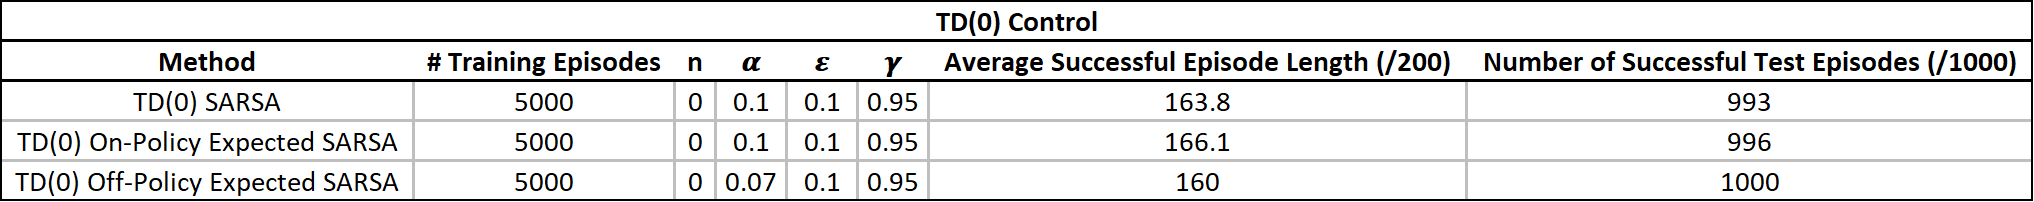

##**Discussion**

From the table, we see that TD(0) Off-Policy Expected SARSA performed the best, as all its 1000 test episodes were successful, and the length of successful episodes was shorter than that resulting from the other two methods. However, we can't rule out the possibility that with further tuning of parameters, the ranking of methods could be different. Nevertheless, since the results are so close here, it seems all methods are equally viable options.

#**Exercise 2: TD(n)**

A useful ungraded exercise. Develop code for TD(n) predication, n-step SARSA (on-policy) control and off-policy Tree Backup control.

Test it out.

**Text Response:** n-SARSA on policy and off-policy Tree Backup control were implemented. Please observe results below... The algorithms themselves can be found in the 'Helper Functions' section, under the 'TD Control Helper Functions' subsection.

##**n-step SARSA Testing**


In [91]:
pi_f_N_SARSA_2, q_f_N_SARSA_2 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'SARSA', n = 2,  alpha = 0.1, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -2.873
   Cumulative Average Episode Length =  188.573 / 200  ( 0.9428650000000001 )
   Cumulative Successful Episode Count =  332 / 1000  ( 0.332 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  -2.873
   Batch Average Episode Length =  188.573 / 200  ( 0.9428650000000001 )
   Batch Successful Episode Count =  332 / 1000  ( 0.332 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -4.6975
   Cumulative Average Episode Length =  189.511 / 200  ( 0.9475549999999999 )
   Cumulative Successful Episode Count =  628 / 2000  ( 0.314 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  -6.522
   Batch Average Episode Length =  190.449 / 200  ( 0.952245 )
   Batch Successful Episode Count =  296 / 1000  ( 0.296 )

3000  ep

###Performance Result

In [92]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_N_SARSA_2, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  964 / 1000
Fraction of Successful Episodes =  0.964
Average of Average Successful Episode Steps per Trial =  152.09392190715323 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7604696095357661


##**Off Policy Tree Backup Testing**

In [105]:
pi_f_TREE_BACKUP_2, q_f_TREE_BACKUP_2 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'TREE_BACKUP', n = 2,  alpha = 0.03, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  81.996
   Cumulative Average Episode Length =  158.457 / 200  ( 0.792285 )
   Cumulative Successful Episode Count =  956 / 1000  ( 0.956 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  81.996
   Batch Average Episode Length =  158.457 / 200  ( 0.792285 )
   Batch Successful Episode Count =  956 / 1000  ( 0.956 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  85.221
   Cumulative Average Episode Length =  157.4315 / 200  ( 0.7871575 )
   Cumulative Successful Episode Count =  1956 / 2000  ( 0.978 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  88.446
   Batch Average Episode Length =  156.406 / 200  ( 0.78203 )
   Batch Successful Episode Count =  1000 / 1000  ( 1.0 )

3000  episodes completed... out of  50

###Performance Result

In [106]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_TREE_BACKUP_2, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  1000 / 1000
Fraction of Successful Episodes =  1.0
Average of Average Successful Episode Steps per Trial =  155.765 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7788249999999999


#**Task 2: TD(2), TD(3), TD(4)**

Code controllers for TD(2), TD(3), and TD(4) using n-SARSA. Assess performance and compare against TD(0) and each other.

You may choose to use your work from Ex 2 for this (if you did Ex 2); otherwise you can code specific solvers for TD(2/3/4).

##**TD(2) n-SARSA**

In [108]:
pi_f_N_SARSA_2, q_f_N_SARSA_2 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'SARSA', n = 2,  alpha = 0.1, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -1.801
   Cumulative Average Episode Length =  188.825 / 200  ( 0.944125 )
   Cumulative Successful Episode Count =  295 / 1000  ( 0.295 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  -1.801
   Batch Average Episode Length =  188.825 / 200  ( 0.944125 )
   Batch Successful Episode Count =  295 / 1000  ( 0.295 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -0.165
   Cumulative Average Episode Length =  186.368 / 200  ( 0.93184 )
   Cumulative Successful Episode Count =  718 / 2000  ( 0.359 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  1.471
   Batch Average Episode Length =  183.911 / 200  ( 0.919555 )
   Batch Successful Episode Count =  423 / 1000  ( 0.423 )

3000  episodes completed... out of  5000 

###Performance Result

965 successful test episodes out of 1000.

In [109]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_N_SARSA_2, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  965 / 1000
Fraction of Successful Episodes =  0.965
Average of Average Successful Episode Steps per Trial =  184.5825874607475 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.9229129373037375


##**TD(3) n-SARSA**

In [116]:
pi_f_N_SARSA_3, q_f_N_SARSA_3 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'SARSA', n = 3,  alpha = 0.1, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -2.79
   Cumulative Average Episode Length =  189.837 / 200  ( 0.949185 )
   Cumulative Successful Episode Count =  338 / 1000  ( 0.338 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  -2.79
   Batch Average Episode Length =  189.837 / 200  ( 0.949185 )
   Batch Successful Episode Count =  338 / 1000  ( 0.338 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  -6.0455
   Cumulative Average Episode Length =  188.546 / 200  ( 0.94273 )
   Cumulative Successful Episode Count =  684 / 2000  ( 0.342 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  -9.301
   Batch Average Episode Length =  187.255 / 200  ( 0.936275 )
   Batch Successful Episode Count =  346 / 1000  ( 0.346 )

3000  episodes completed... out of  5000 

###Performance Result

979 successful test episodes out of 1000.

In [117]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_N_SARSA_3, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  979 / 1000
Fraction of Successful Episodes =  0.979
Average of Average Successful Episode Steps per Trial =  150.4693976335215 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7523469881676076


##**TD(4) n-SARSA**

In [136]:
pi_f_N_SARSA_4, q_f_N_SARSA_4 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'SARSA', n = 4,  alpha = 0.06, eps = 0.08, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  31.944
   Cumulative Average Episode Length =  179.875 / 200  ( 0.899375 )
   Cumulative Successful Episode Count =  506 / 1000  ( 0.506 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  31.944
   Batch Average Episode Length =  179.875 / 200  ( 0.899375 )
   Batch Successful Episode Count =  506 / 1000  ( 0.506 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  33.415
   Cumulative Average Episode Length =  180.2825 / 200  ( 0.9014125 )
   Cumulative Successful Episode Count =  1027 / 2000  ( 0.5135 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  34.886
   Batch Average Episode Length =  180.69 / 200  ( 0.90345 )
   Batch Successful Episode Count =  521 / 1000  ( 0.521 )

3000  episodes completed... out of  5

###Performance Result

998 successful test episodes out of 1000.

In [137]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_N_SARSA_4, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  998 / 1000
Fraction of Successful Episodes =  0.998
Average of Average Successful Episode Steps per Trial =  144.13179591836735 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7206589795918368


##**Summary Table**

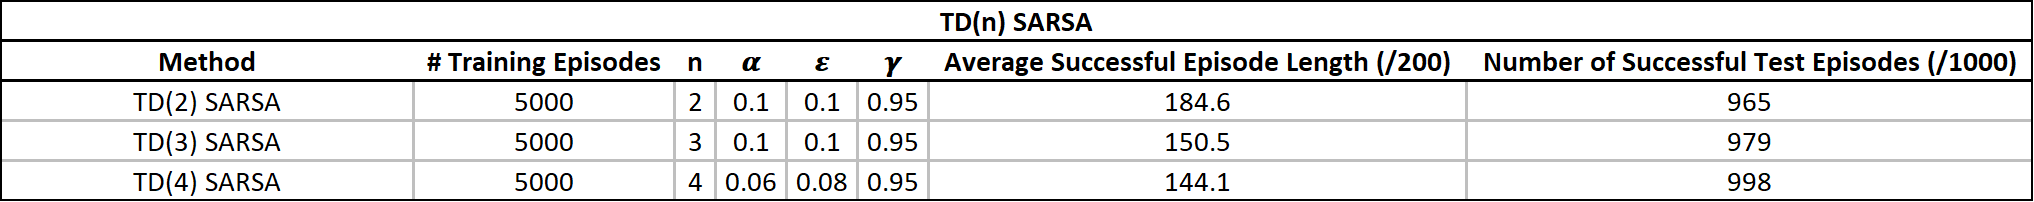

##**Discussion**

From the table, we see an increase in performance as n is increased - an intuitive result. However we notice that TD(2) SARSA performed worse than TD(0) SARSA in the previous task. This may be a matter of tuning the parameters differently to generate different results. However the results in TD(4) are a great improvement, as we observe the lowest `'Average Successful Episode Length'` yet, and a vary high count of successful episodes.

#**Bonus Task 3: Tree Backup**

This is optional; if you do this, your grade can exceed 100% and will offset other grades.

Assess the performance of Tree Backup for TD(2), TD(3), and TD(4) versus the respective n-SARSA controller.

##**TD(2) Tree Backup**

In [147]:
pi_f_TREE_BACKUP_2, q_f_TREE_BACKUP_2 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'TREE_BACKUP', n = 2,  alpha = 0.03, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  81.757
   Cumulative Average Episode Length =  160.344 / 200  ( 0.80172 )
   Cumulative Successful Episode Count =  954 / 1000  ( 0.954 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  81.757
   Batch Average Episode Length =  160.344 / 200  ( 0.80172 )
   Batch Successful Episode Count =  954 / 1000  ( 0.954 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  85.023
   Cumulative Average Episode Length =  159.398 / 200  ( 0.79699 )
   Cumulative Successful Episode Count =  1954 / 2000  ( 0.977 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  88.289
   Batch Average Episode Length =  158.452 / 200  ( 0.79226 )
   Batch Successful Episode Count =  1000 / 1000  ( 1.0 )

3000  episodes completed... out of  5000 **

###Performance Result

1000 successful episodes out of 1000 test episodes.

In [148]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_TREE_BACKUP_2, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  1000 / 1000
Fraction of Successful Episodes =  1.0
Average of Average Successful Episode Steps per Trial =  157.89499999999998 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7894749999999999


##**TD(3) Tree Backup**

In [160]:
pi_f_TREE_BACKUP_3, q_f_TREE_BACKUP_3 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'TREE_BACKUP', n = 3,  alpha = 0.05, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  74.036
   Cumulative Average Episode Length =  155.55 / 200  ( 0.77775 )
   Cumulative Successful Episode Count =  990 / 1000  ( 0.99 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  74.036
   Batch Average Episode Length =  155.55 / 200  ( 0.77775 )
   Batch Successful Episode Count =  990 / 1000  ( 0.99 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  74.166
   Cumulative Average Episode Length =  155.2685 / 200  ( 0.7763424999999999 )
   Cumulative Successful Episode Count =  1990 / 2000  ( 0.995 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  74.296
   Batch Average Episode Length =  154.987 / 200  ( 0.7749349999999999 )
   Batch Successful Episode Count =  1000 / 1000  ( 1.0 )

3000  episodes completed

###Performance Result

1000 successful episodes out of 1000 test episodes.

In [161]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_TREE_BACKUP_3, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  1000 / 1000
Fraction of Successful Episodes =  1.0
Average of Average Successful Episode Steps per Trial =  154.985 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.7749250000000001


##**TD(4) Tree Backup**

In [157]:
pi_f_TREE_BACKUP_4, q_f_TREE_BACKUP_4 = TD_CONTROL(env, pi_greedy_i, q_i, method = 'TREE_BACKUP', n = 4,  alpha = 0.07, eps = 0.1, gamma = 0.95, episode_count = 5000)

1000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  73.611
   Cumulative Average Episode Length =  155.956 / 200  ( 0.7797799999999999 )
   Cumulative Successful Episode Count =  894 / 1000  ( 0.894 )

 Batch Statistics (episodes  1  to  1000 ):
   Batch Average Reward =  73.611
   Batch Average Episode Length =  155.956 / 200  ( 0.7797799999999999 )
   Batch Successful Episode Count =  894 / 1000  ( 0.894 )

2000  episodes completed... out of  5000 ****************************************
 Cumulative Statistics:
   Cumulative Average Reward =  74.732
   Cumulative Average Episode Length =  153.034 / 200  ( 0.7651699999999999 )
   Cumulative Successful Episode Count =  1894 / 2000  ( 0.947 )

 Batch Statistics (episodes  1001  to  2000 ):
   Batch Average Reward =  75.853
   Batch Average Episode Length =  150.112 / 200  ( 0.75056 )
   Batch Successful Episode Count =  1000 / 1000  ( 1.0 )

3000  epis

###Performance Result

1000 successful episodes out of 1000 test episodes.

In [158]:
MountainCar_TEST(trial_count = 20, episode_count = 50, policy_input = pi_f_TREE_BACKUP_4, display_trial_readout = False, display_episode_readout = False)

CUMULATIVE RESULTS:
Total Number of Successful Episodes =  1000 / 1000
Fraction of Successful Episodes =  1.0
Average of Average Successful Episode Steps per Trial =  150.10399999999998 / 200
Average of Average Successful Episode Steps per Trial (Fractional) =  0.75052


##**Summary Table**

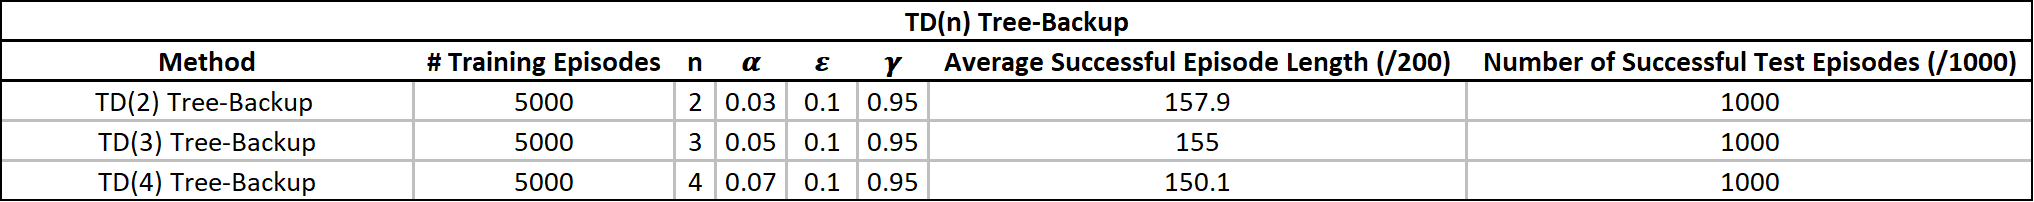

##**Discussion**

As we clearly see here, Tree Backup performs astoundingly for all 3 cases of 'n' analyzed. 'Average Successful Episode Length' descreases as 'n' increases, which is both an expected and encouraging result. For all 'n', every test episode is successful.

#**Concluding Remarks**

We have seen the performance of a variety of TD-Controllers. From the results, it appears that Tree Backup is the most reliable option (for all n values we've attempted). However, it should be noted that TD(0) Off-Policy Expected SARSA produced the best result out of all control algorithms (lowest number of steps needed to reach the flag, with all episodes being successful). Through these tasks, I've found that hyperparameter selection, particularly the choice of $\alpha$ is critical to the speed towards which the MC converges to an optimal policy.